## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the RU-EN translation task.

Basic approach using RNNs as encoder and decoder is implemented for you.

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism (**highly recommended**)

* custom tokenization (BPE units, other subword approaches)

to improve the translation quality.

--------

* __Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

* Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [73]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



#### Grading criteria

**100%**
- implementation of at least 3 model improvements over baseline
- threshold of 27 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**70%**
- implementation of at least 2 model improvements over baseline
- threshold of 25 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**30%**
- implementation of at least 1 model improvement over baseline
- threshold of 21 BLEU on test corpus
- experimental results and conclusions in human-readable format :)


------

#### **Note: Please do not use pretrained machine translation / BERT / LLM checkpoints. All such solutions will be graded at 30% pts.**


### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface:
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [3]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
# from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


/home/pavel/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

First of all, we will do the data preprocessing. In this task, we've got a dataset, that contains a lot of pairs of the parallel sentenses. Source language is english and the destination one -- russian.

To preprocess this pairs of sentenses, we split all of the sentenses to the tokens, using a tokenizer function. After that we build a vocabulary of the unic tokens for both languages and represent all of the words in all sentenses as an index of this word in a vocabular. By this way we move from the real words to it's encodings.

In [4]:
# here is an instrument for smart tokenize the input sentence
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

Field is a bacis structure of the torchtext module; it provide us to define the preprocessing pipeline of our data.

In [5]:
SRC = Field(tokenize=tokenize, #  The function used to tokenize strings using this field into sequential examples
            init_token = '<sos>', # A token that will be prepended to every example using this field
            eos_token = '<eos>', #  A token that will be appended to every example using this field
            lower = True) # to lowercase the text in this field

TRG = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

dataset = torchtext.legacy.data.TabularDataset(
    path=path_do_data,
    format='tsv', # The format of the data file. One of “CSV”, “TSV”, or “JSON”
    fields=[('trg', TRG), ('src', SRC)]
)

In [6]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

Lets take a look on preprocessed data.

In [7]:
vars(train_data.examples[1])

{'trg': ['the',
  'air',
  '-',
  'conditioned',
  'country',
  'house',
  'features',
  'a',
  'terrace',
  'with',
  'impressive',
  'views',
  'of',
  'the',
  'mountains',
  'and',
  'the',
  'village',
  '.'],
 'src': ['к',
  'услугам',
  'гостей',
  'кондиционер',
  'и',
  'терраса',
  'с',
  'потрясающим',
  'видом',
  'на',
  'горы',
  'и',
  'деревню',
  '.']}

In [8]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


On this step we not only build the vocab, but also encode tokens to the vectors; to tell the truth we even don't really encode it, we juct make smth live string2idx, and in the translation function we will be able to use predected vector of indexes to build the words in translated sentense.
In addition we append the token <unk> to the vocab.

In the nn we will have the embedding layer; why do we need it if we've already encoded our tokens on this step? We do it, cz in the RNN we must have the vectors of the same dimention, so, by   using embedding layer, we make a static internal RNN representation vector dimention.

In [9]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [10]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9300
Unique tokens in target (en) vocabulary: 6748


Here are tokens from original (RU) corpus:

In [11]:
SRC.vocab.itos[::1000]

['<unk>',
 'современными',
 'термальные',
 'любимые',
 'тур',
 'тель',
 'giardino',
 'сэндвичи',
 'гуэль',
 'столице']

And from target (EN) corpus:

In [12]:
TRG.vocab.itos[::1000]

['<unk>', 'very', 'inclusive', 'chianti', 'massira', 'skis', 'logis']

And here is example from train dataset:

In [13]:
print(vars(train_data.examples[9]))

{'trg': ['free', 'parking', 'spaces', 'are', 'available', 'on', 'site', '.'], 'src': ['на', 'территории', 'обустроена', 'бесплатная', 'парковка', '.']}


Let's check the length distributions:

Length distribution in Train data


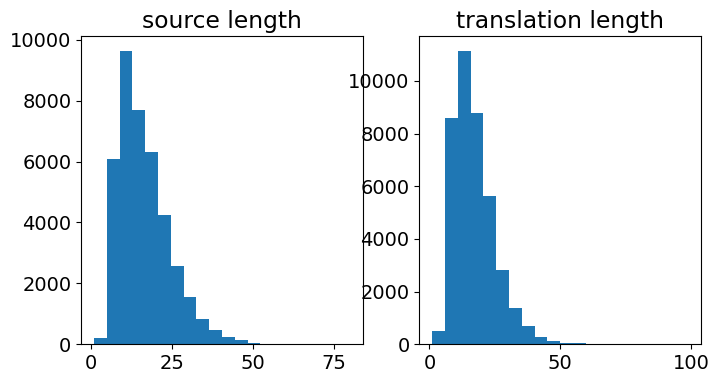

In [14]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


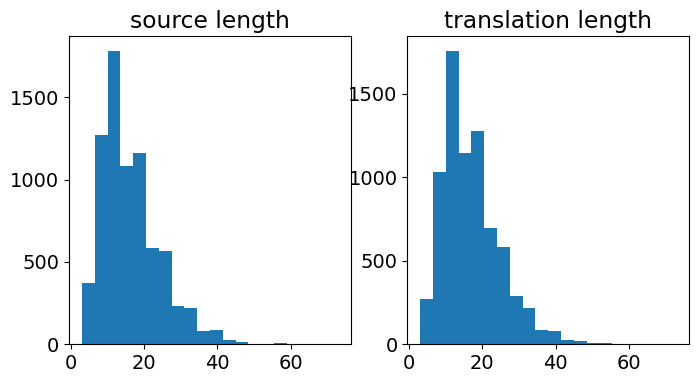

In [15]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week02 practice__

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
device

device(type='cpu')

In [18]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key
)

In [19]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)
# the first dimention of tensor is a max length of the item
# the second dimention of the tensor is a number of items


[torchtext.legacy.data.batch.Batch of size 128]
	[.trg]:[torch.LongTensor of size 43x128]
	[.src]:[torch.LongTensor of size 43x128]
torch.Size([43, 128]) torch.Size([43, 128])


Lets try to output one of the tensors. We can see and assume, that the first number in each column is 2 and it's represent the <sos> token and we have a lot of 1 number, we can assume, it's represent a <pad> token.

In [20]:
print(x.src)

tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [ 136,  355,   15,  ...,    5,  161,  107],
        [  13, 1025,  493,  ...,   38,    0,  109],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])


In the first stage we will check on the basic seq2seq model without attention and any kind of optimisation.

## Simple Seq2seq model

In [21]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [22]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [23]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9300, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6748, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6748, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,926,428 trainable parameters


In [25]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
from utils import evaluate, train, write_model_title_log, write_model_train_log

train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

In [28]:
write_model_title_log("logfile.log", 
                      f"[MODEL = Seq2Seq]\n")

I moved train and evaluate functions to utils model to not to overload notebook.
Now we're ready to train our first model and check it's progress. To view more details about learning, check out the logfile (I redirect logs to this file).

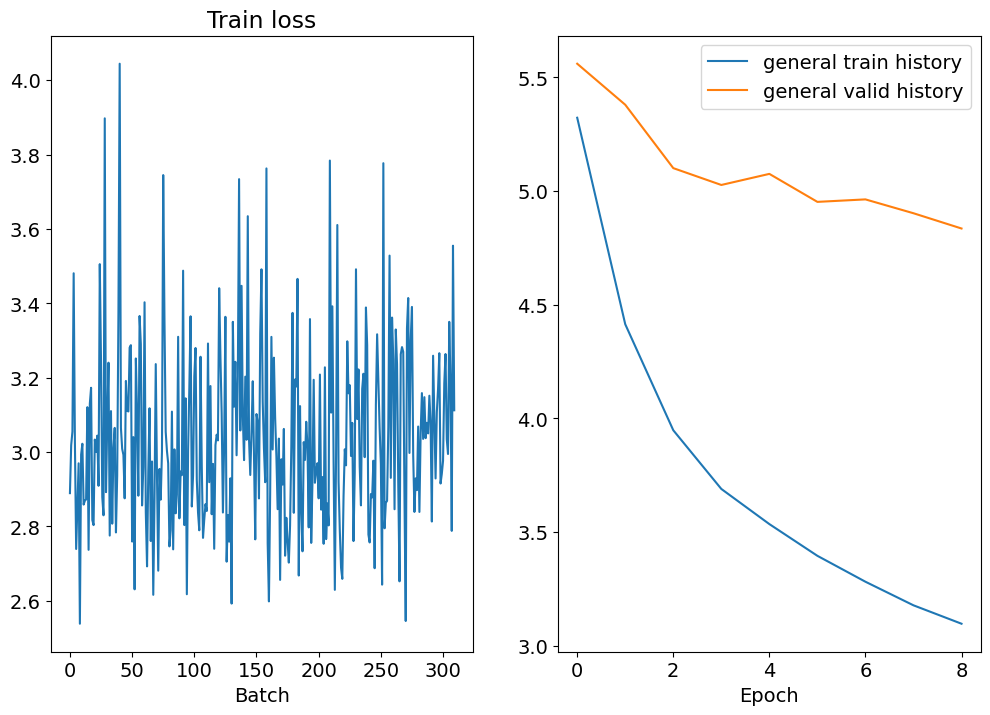

In [29]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'simple_seq2seq.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    write_model_train_log("logfile.log",
                          epoch,
                          [epoch_mins, epoch_secs],
                          train_loss,
                          valid_loss)

On the last epoch we could see that the train loss on the left plot is not decrease anymore. That means, that the model came tho the point of the local min.

PPL stands for perplexity. This quantity is directly computable from the negative log-likelihood (and the number of samples), 
so it's odd that the authors would report both.

__Let's take a look at our network quality__:

In [30]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

/tmp/ipykernel_475078/3680124227.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [31]:
batch = next(iter(test_iterator))

Lets check an example of the our model translation.

In [32]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: free wi - fi is included .
Generated: free wifi access is available in all areas .

Original: free parking is possible nearby .
Generated: guests can enjoy the on - site parking .



So, now it's time to calculate some score to examine the translation model quality. To do it, we will use BLEU score.

In [33]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [34]:
'''
tqdm means "progress" in Arabic 
and is an abbreviation for "I love you so much" in Spanish (te quiero demasiado).
'''
import tqdm

In [35]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:13,  4.53it/s]


The BLEU is a one way how to evaluate the quality of the machine translating. Original BLEU uses a counting of the same words, bigramms, etc and accumulate it to the one score. Corpus_bleu is able to give an input of several sentenses and it's translations and makes some kind of average BLEU score of all of this transaltions.

In [36]:
seq2seq_model_bleu_score = corpus_bleu([[text] for text in original_text], generated_text) * 100
seq2seq_model_bleu_score

12.81381047982269

For now lets try to make a mechanism of self attention in exested Seq2seq nn. In this model we didn't write smth special. We just add the mechanism of attention to the previous model.

## Seq2Seq + attention

In [37]:
import attention_nn
AttentionEncoder = attention_nn.Encoder
AttentionDecoder = attention_nn.Decoder
AttentionSeq2Seq = attention_nn.Seq2Seq

In [38]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = AttentionEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = AttentionDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)


# dont forget to put the model to the right device
model = AttentionSeq2Seq(enc, dec, device).to(device)

In [39]:
model.apply(init_weights)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,926,428 trainable parameters


In [40]:
PAD_IDX = TRG.vocab.stoi['']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [41]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 5

best_valid_loss = float('inf')

In [42]:
write_model_title_log("logfile.log", 
                      f"[MODEL = Seq2Seq + attention]\n")

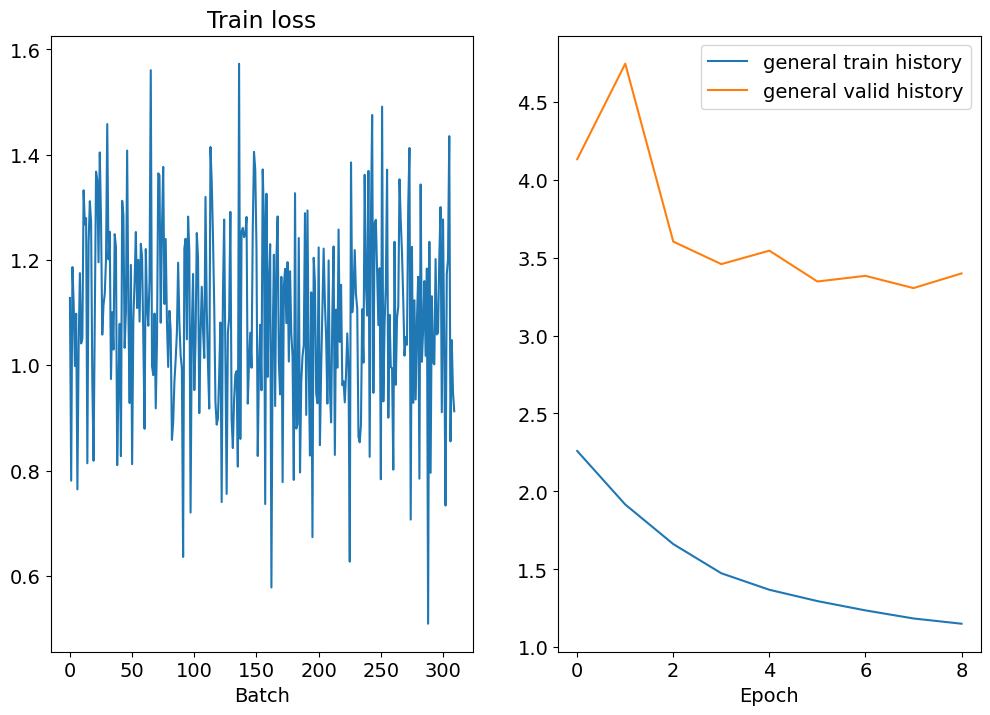

In [43]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attention.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    write_model_train_log("logfile.log",
                          epoch,
                          [epoch_mins, epoch_secs],
                          train_loss,
                          valid_loss)

In [44]:
batch = next(iter(test_iterator))

In [45]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: free wi - fi is included .
Generated: free wifi access .

Original: free parking is possible nearby .
Generated: free private parking is available .



In [46]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

59it [00:12,  4.57it/s]


In [47]:
seq2seq_with_attention_model_bleu_score = corpus_bleu([[text] for text in original_text], generated_text) * 100
seq2seq_model_bleu_score

12.81381047982269

Now lets see on the most powerful model in this task -- transformer with self attention mechanism.

## Transformer

In [48]:
import transformer
from transformer import Seq2SeqTransformer

In [49]:
torch.manual_seed(0)
PAD_IDX = TRG.vocab.stoi['']


SRC_VOCAB_SIZE = len(SRC.vocab)
TGT_VOCAB_SIZE = len(TRG.vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, 
                                 NUM_DECODER_LAYERS, 
                                 EMB_SIZE, 
                                 NHEAD, 
                                 SRC_VOCAB_SIZE, 
                                 TGT_VOCAB_SIZE, 
                                 FFN_HID_DIM)

In [50]:
for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [51]:
transformer = transformer.to(device)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

A couple of words about masks.

Here we have to generate a couple types of masks: mask for attention mechanism and mask for padding ignoring. The first one type is using for effective calculation of the attention vectors. The second one needs to the ignore padding in the sentenses.

More information:
1) https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
2) https://stackoverflow.com/questions/62170439/difference-between-src-mask-and-src-key-padding-mask
3) ask Chat GPT for an answer

In [52]:
from transformer import generate_square_subsequent_mask

def create_mask(src, tgt, DEVICE):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len, DEVICE)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

Also for this model we need a little bit different functions of the train and evaluate functions, cz of the using masks.

In [53]:
def train_epoch(model, 
                optimizer, 
                iterator, 
                DEVICE, 
                train_history=None, 
                valid_history=None):
    model.train()
    losses = 0
    history = []
    
    for i, batch in enumerate(iterator):
        src = batch.src.to(DEVICE)
        tgt = batch.trg.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)

        logits = model(src, 
                       tgt_input, 
                       src_mask, 
                       tgt_mask,
                       src_padding_mask, 
                       tgt_padding_mask, 
                       src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
        # plot
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        

    return losses / len(iterator)


def evaluate(model, 
             iterator, 
             DEVICE):
    model.eval()
    losses = 0

    for i, batch in enumerate(iterator):
        src = batch.src.to(DEVICE)
        tgt = batch.trg.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(iterator)

In [54]:
print(f'The model has {count_parameters(transformer):,} trainable parameters')

The model has 24,303,196 trainable parameters


In [55]:
write_model_title_log("logfile.log", 
                      f"[MODEL = Transformer]\n")

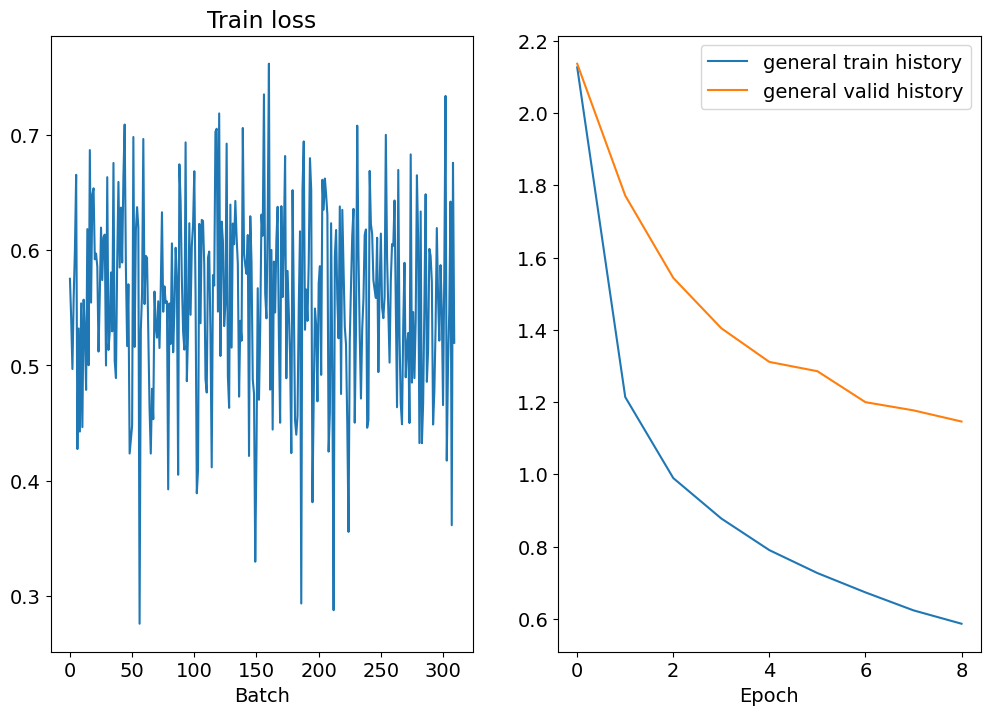

In [56]:
train_history = []
valid_history = []
from timeit import default_timer as timer
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, train_iterator, device, train_history, valid_history)
    end_time = timer()
    val_loss = evaluate(transformer, valid_iterator, device)
    train_history.append(train_loss)
    valid_history.append(val_loss)
    write_model_train_log("logfile.log",
                          epoch,
                          [epoch_mins, epoch_secs],
                          train_loss,
                          valid_loss)

In [57]:
transformer.eval()
original_text = []
generated_text = []

with torch.no_grad():

  for i, batch in tqdm.tqdm(enumerate(test_iterator)):
      src = batch.src.to(device)
      tgt = batch.trg.to(device)

      tgt_input = tgt[:-1, :]

      src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, device)

      logits = transformer(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
      
      tgt_out = tgt[1:, :]
      logits = logits.argmax(dim=-1)
      generated_text.extend([get_text(x, TRG.vocab) for x in logits.cpu().numpy().T])
      original_text.extend([get_text(x, TRG.vocab) for x in tgt.cpu().numpy().T])

59it [00:14,  4.10it/s]


In [58]:
transformer_model_bleu_score = corpus_bleu([[text] for text in original_text], generated_text) * 100
transformer_model_bleu_score

29.07547039632773

On the last step we come back to the first model, but test a little bit different method to tokenise the source sentenses. In this section we will see, how the BPE encoding influence on the simple seq2seq model.

Revise the https://huggingface.co/learn/nlp-course/chapter6/5 about BPE tokenisation method.

## Using BPE

In [74]:
import sentencepiece as spm
import pandas as pd

#! So, we know, that in the data file we have 2 columns the first one -- sentense in english and the second one -- the sentense in russian
data = pd.read_csv(path_do_data, sep = "\t", header = None).sample(frac = .8)

#! We separate this sentenses to the independent files
data[1].to_csv("ru.txt", sep = '\t', header = False, index = False)
data[0].to_csv("eng.txt", sep = '\t', header = False, index = False)

#! now we have a sentensen in english and russian, so, we can to train bpe tokenizer on this sentenses to use it later to build a vocabulary of tokens
spm.SentencePieceTrainer.train(input = 'ru.txt', model_prefix = 'm_ru', vocab_size = 2500, model_type = 'bpe')
spm.SentencePieceTrainer.train(input = 'eng.txt', model_prefix = 'm_eng', vocab_size = 2500, model_type = 'bpe')

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ru.txt
  input_format: 
  model_prefix: m_ru
  model_type: BPE
  vocab_size: 2500
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privac

The BPE tokenisation model is similar to the ml model itself, cz we learn it on the data we have and can save to the file. Note, that we save tokenisers for english and russian languages independent.

In [96]:

#! trained bpe tokenise models are saved in .model files
def bpe_tokenizer_en(x):
  return spm.SentencePieceProcessor(model_file = 'm_eng.model').encode(x, out_type = str)

def bpe_tokenizer_ru(x):
  return spm.SentencePieceProcessor(model_file = 'm_ru.model').encode(x, out_type = str)

In [97]:

#! for this moment we already have trained tokenisers for english and russian, so, we use it to encode the data to the indexes
SRC = Field(tokenize=bpe_tokenizer_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            fix_length = 100, # need is we use bpe tokenesation
            lower = True)

TRG = Field(tokenize=bpe_tokenizer_ru,
            init_token = '<sos>',
            eos_token = '<eos>',
            fix_length = 100,
            lower = True)

dataset = torchtext.legacy.data.TabularDataset(
    path=path_do_data,
    format='tsv', # The format of the data file. One of “CSV”, “TSV”, or “JSON”
    fields=[('trg', TRG), ('src', SRC)]
)

In [98]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [99]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [100]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [101]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 8791
Unique tokens in target (en) vocabulary: 391


In [109]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key
)

In [110]:
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [111]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [112]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8791, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(391, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=391, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [113]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,907,591 trainable parameters


In [114]:
PAD_IDX = TRG.vocab.stoi['']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [115]:
from utils import evaluate, train, write_model_title_log, write_model_train_log

train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

In [86]:
write_model_title_log("logfile.log", 
                      f"[MODEL = Seq2Seq BPE tokenisation]\n")

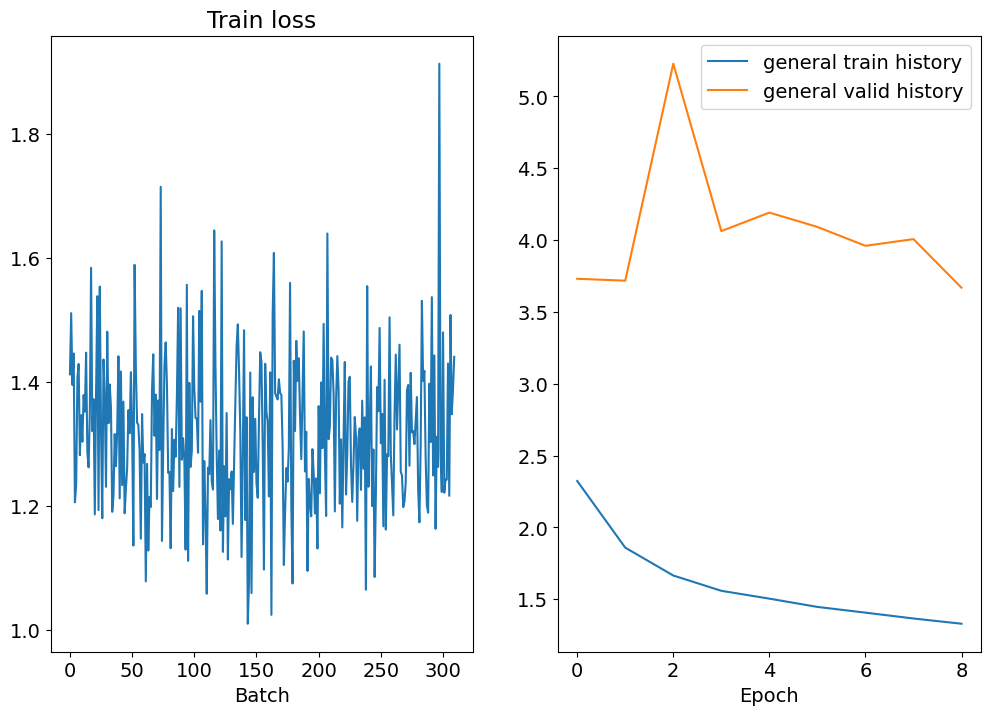

In [116]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'seq2seq_bpe.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    write_model_train_log("logfile.log",
                          epoch,
                          [epoch_mins, epoch_secs],
                          train_loss,
                          valid_loss)

In [117]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [118]:
batch = next(iter(test_iterator))

In [119]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:27,  2.17it/s]


In [120]:
seq2seq_bpe_model_bleu_score = corpus_bleu([[text] for text in original_text], generated_text) * 100
seq2seq_bpe_model_bleu_score

19.966732986452026

In [121]:
bleu_scores = [
    seq2seq_model_bleu_score,
    seq2seq_with_attention_model_bleu_score,
    transformer_model_bleu_score,
    seq2seq_bpe_model_bleu_score
]
models = [
    "seq2seq",
    "seq2seq + attention",
    "transformer",
    "seq2seq + bpe"
]

In [122]:
def add_bar_labels(obj_x, obj_y) -> None:
    for x, y in zip(obj_x, obj_y):
        plt.text(x, y, round(y, 3), ha='center')

Text(0.5, 1.0, 'BLEU score of the tested models')

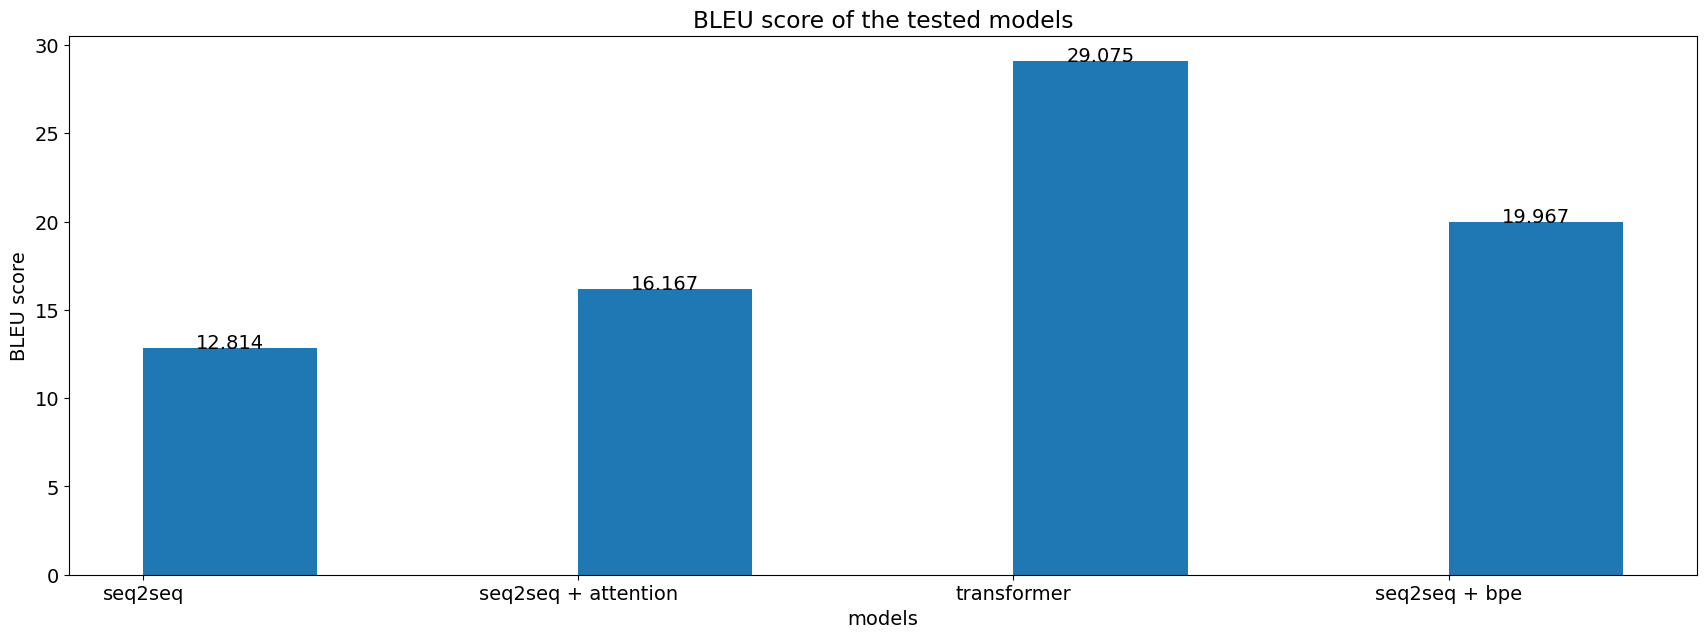

In [123]:
import numpy as np

x_ticks = np.arange(0, len(models)*5, 5)
standart_width = 2

fig = plt.figure(figsize=(21, 7))

plt.bar(x_ticks + standart_width/2, bleu_scores, width=standart_width)
add_bar_labels(x_ticks + standart_width/2, bleu_scores)

plt.xticks(x_ticks, models)
plt.xlabel("models")
plt.ylabel("BLEU score")
plt.title(f"BLEU score of the tested models")

## Conclusion

In this notebook we have compared 3 different model of the neural machine translating, also discovered how BPE tokenisation influences on the model quality. Lets accumulate basic results of the experiment in a table:

models    | Basic Seq2Sqeq | Seq2Seq with attention | Transformer | Basic Seq2Sqeq with BPE 
----------|------------------|-----------------------|----------------------|-----------
Bleu score| 12.814 | 16.167 | 29.075 | 19.967

As we can see, simple seq2seq model is the simplest, but the most weak result. Most powerful is a Transformer model, because of using self attention mechanism.

Also, we can see, that BPE tokenisation technique can boost even weak model and provide to encrease it's quality score.

Moreover, by revising the notes of traning in logfile we can compare how fast each model converges to a solution.

Simple seq2seq model:
```
Epoch: 01 | Time: 11m 34s
	Train Loss: 5.323 | Train PPL: 204.902
	Val. Loss: 5.560 |  Val. PPL: 259.865
Epoch: 02 | Time: 11m 32s
	Train Loss: 4.414 | Train PPL:  82.617
	Val. Loss: 5.380 |  Val. PPL: 216.959
...
Epoch: 09 | Time: 11m 45s
	Train Loss: 3.097 | Train PPL:  22.129
	Val. Loss: 4.835 |  Val. PPL: 125.886
Epoch: 10 | Time: 11m 46s
	Train Loss: 3.035 | Train PPL:  20.806
	Val. Loss: 4.842 |  Val. PPL: 126.738
```

Seq2seq + attention
```
Epoch: 01 | Time: 11m 41s
	Train Loss: 2.259 | Train PPL:   9.578
	Val. Loss: 4.130 |  Val. PPL:  62.204
Epoch: 02 | Time: 11m 39s
	Train Loss: 1.916 | Train PPL:   6.795
	Val. Loss: 4.743 |  Val. PPL: 114.774
...
Epoch: 09 | Time: 11m 35s
	Train Loss: 1.152 | Train PPL:   3.163
	Val. Loss: 3.398 |  Val. PPL:  29.908
Epoch: 10 | Time: 11m 41s
	Train Loss: 1.088 | Train PPL:   2.968
	Val. Loss: 3.296 |  Val. PPL:  26.992
```

Transformer:
```
Epoch: 01 | Time: 11m 41s
	Train Loss: 2.127 | Train PPL:   8.388
	Val. Loss: 3.296 |  Val. PPL:  26.992
Epoch: 02 | Time: 11m 41s
	Train Loss: 1.214 | Train PPL:   3.367
	Val. Loss: 3.296 |  Val. PPL:  26.992
...
Epoch: 09 | Time: 11m 41s
	Train Loss: 0.587 | Train PPL:   1.798
	Val. Loss: 3.296 |  Val. PPL:  26.992
Epoch: 10 | Time: 11m 41s
	Train Loss: 0.556 | Train PPL:   1.744
	Val. Loss: 3.296 |  Val. PPL:  26.992
```

seq2seq with BPE tokenisation
```
Epoch: 01 | Time: 10m 28s
	Train Loss: 2.323 | Train PPL:  10.206
	Val. Loss: 3.731 |  Val. PPL:  41.712
Epoch: 02 | Time: 10m 33s
	Train Loss: 1.859 | Train PPL:   6.417
	Val. Loss: 3.718 |  Val. PPL:  41.165
...
Epoch: 09 | Time: 10m 38s
	Train Loss: 1.329 | Train PPL:   3.779
	Val. Loss: 3.668 |  Val. PPL:  39.188
Epoch: 10 | Time: 10m 35s
	Train Loss: 1.318 | Train PPL:   3.735
	Val. Loss: 3.687 |  Val. PPL:  39.919
```

models    | Basic Seq2Sqeq | Seq2Seq with attention | Transformer | Basic Seq2Sqeq with BPE 
----------|------------------|-----------------------|----------------------|-----------
Train loss after 1st epoch| 5.323 | 2.259 | 2.127 | 2.323
Validation loss after 1st epoch| 5.560 | 4.130 | 3.296 | 3.731
Train loss after last epoch| 3.035 | 1.088 | 0.556 | 1.329
Validation loss after last epoch| 4.842 | 3.296 | 3.296 | 3.718
Final validation PPL| 126.738 | 26.992 | 26.992 | 41.165

By revising this table we can not only make a conclusion what of the model is the most powerful, but also compare measure of the boost, that each model add to the basic seq2seq.